<a href="https://colab.research.google.com/github/Vakurin/Tensorflow2-with-TPU-in-Colab/blob/master/SRGAN_TPU_TRAINING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libs

In [0]:
%tensorflow_version 2.x
import math, re, os, time
import tensorflow_addons as tfa
import datetime
date = datetime.datetime.today().strftime("%H-%M-%m-%d-%Y")

try:
  os.environ['COLAB_TPU_ADDR']
except KeyError:
  print('\n\n***Error***\nPlease Turn On TPU(Edit -> Notebook Settings -> TPU)')


import tensorflow as tf
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
from IPython import display
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0


# Setup For Work

## TPU or GPU detection

In [0]:
# TF 2.0
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  #MAIN THINGS ON TPU 
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('\n\n'+'---' * 10 + 'TPU WORKS' + '---' * 10)
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.0.29.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.29.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)




------------------------------TPU WORKS------------------------------
Number of accelerators:  8


## Login In Google Drive And Google Cloud Platform

In [0]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # For access to drive 
  from google.colab import drive
  drive.mount('/content/drive')

  # For access to GCP
  from google.colab import auth
  auth.authenticate_user()
  
else:
  print('Different Env')

## Data access To GCS
TPUs read data directly from Google Cloud Storage (GCS). 

In [0]:
import tensorflow_gcs_config
tensorflow_gcs_config.configure_gcs_from_colab_auth()

[None, <tf.Tensor: shape=(), dtype=int32, numpy=0>]

# Configuration

In [0]:
#EPOCHS = 300000
EPOCHS = 10000

BATCH_SIZE = 4 * strategy.num_replicas_in_sync

IMAGE_SIZE_HR = [256, 256]
IMAGE_SIZE_LR = [64, 64]

GCS_HR_PATH = 'gs://data-srgan/images_bicubic.tfrecords'

# New Generator On Full Images
DRIVE_PRE_GENERATOR_PATH = '/content/drive/My Drive/SRGAN/pre_generator_inet.h5'
DRIVE_GENERATOR_PATH = '/content/drive/My Drive/SRGAN/models_tpu/new-model-generator.h5'


TRAINING_FILENAMES = tf.io.gfile.glob(GCS_HR_PATH)

lr_example = 0.001
coff_cont_loss = 1
coff_gen_loss = 0.001
coff_mse_loss = 1e-6

no_residual_blocks = 16
no_vgg_block = 20

number_of_elements = sum(1 for _ in tf.data.TFRecordDataset(GCS_HR_PATH))
STEPS_PER_EPOCH = number_of_elements // BATCH_SIZE

print('Steps per epoch', STEPS_PER_EPOCH)

lr_optimizers = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries = [200000], values = [1e-3, 5e-4], 
)

Steps per epoch 25


# Dataset

## Visualization Functions

In [0]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images(data):
    images = data
    
    numpy_images = tf.cast(images.numpy(), tf.int32)
    
    return numpy_images


def display_one_image(image, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch):
    """This will work with:
    display_batch_of_images(images)
    """
    # data
    images = batch_to_numpy_images(databatch)
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image) in enumerate(images[:rows*cols]):
        
        correct = True
        
        dynamic_titlesize = FIGSIZE * SPACING / max(rows,cols) * 40 + 3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_image(image, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)    
    plt.show()


## Load From TFRecord Functions

In [0]:
def decode_image_img(image_data):
    image = tf.image.decode_png(image_data, channels=3)
    hr_image = tf.reshape(image, [*IMAGE_SIZE_HR, 3]) # explicit size needed for TPU
    lr_image = tf.image.resize(hr_image, size=[*IMAGE_SIZE_LR])
    # This is for TPU
    lr_image = tf.cast(lr_image, dtype=tf.float32)
    hr_image = tf.cast(hr_image, dtype=tf.float32)
    return lr_image, hr_image

def read_labeled_tfrecord_img(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image_img(example['image'])
    return image

def load_dataset_img(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord_img, num_parallel_calls=AUTO)
    # returns a dataset of image
    return dataset

def get_training_dataset_images():
    dataset = load_dataset_img(TRAINING_FILENAMES)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def int_div_round_up(a, b):
    return (a + b - 1) // b


### Normalization

In [0]:
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5


def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean


def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0


def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1


def denormalize_m11(x):
    """Inverse of normalize_m11."""
    return (x + 1) * 127.5

## Display Images




In [0]:
train_dataset_img = get_training_dataset_images()
for lr, hr in train_dataset_img.unbatch().batch(4).take(1):
  train_hr_img = hr    # [-1, 1] -> [0, 1]
  train_lr_img = lr
  assert train_lr_img.dtype == 'float32'
  assert train_hr_img.dtype == 'float32'

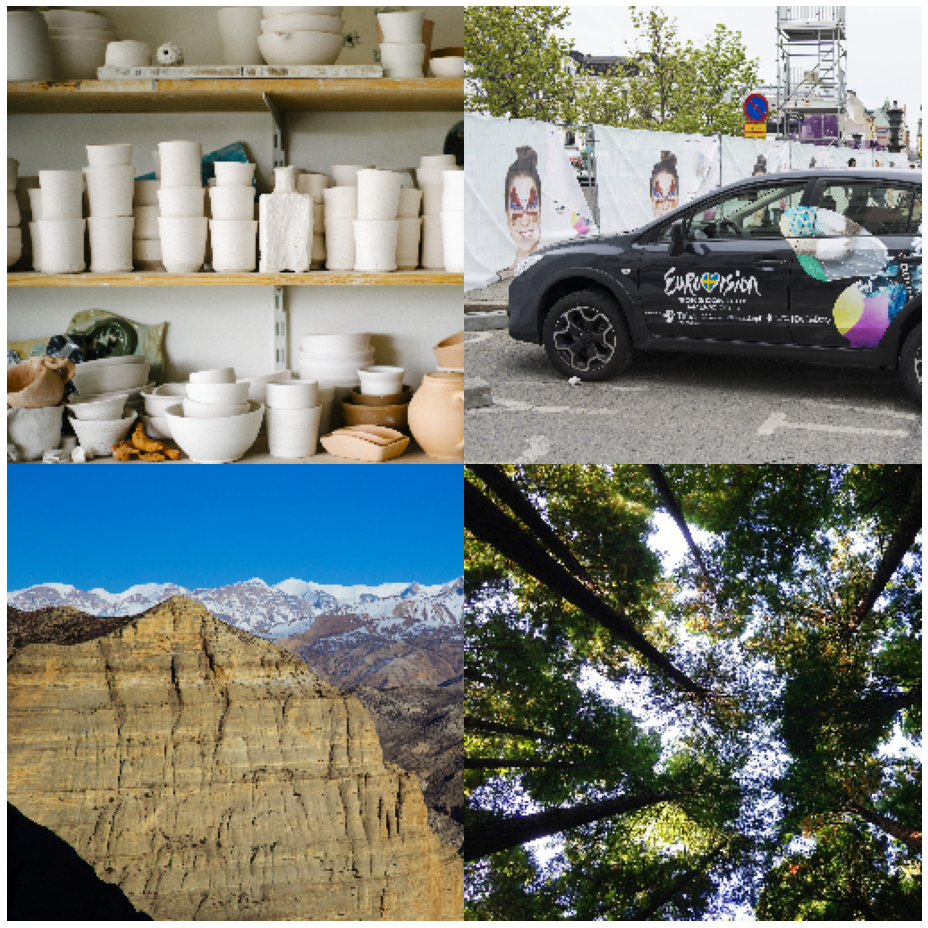

In [0]:
display_batch_of_images(train_hr_img)

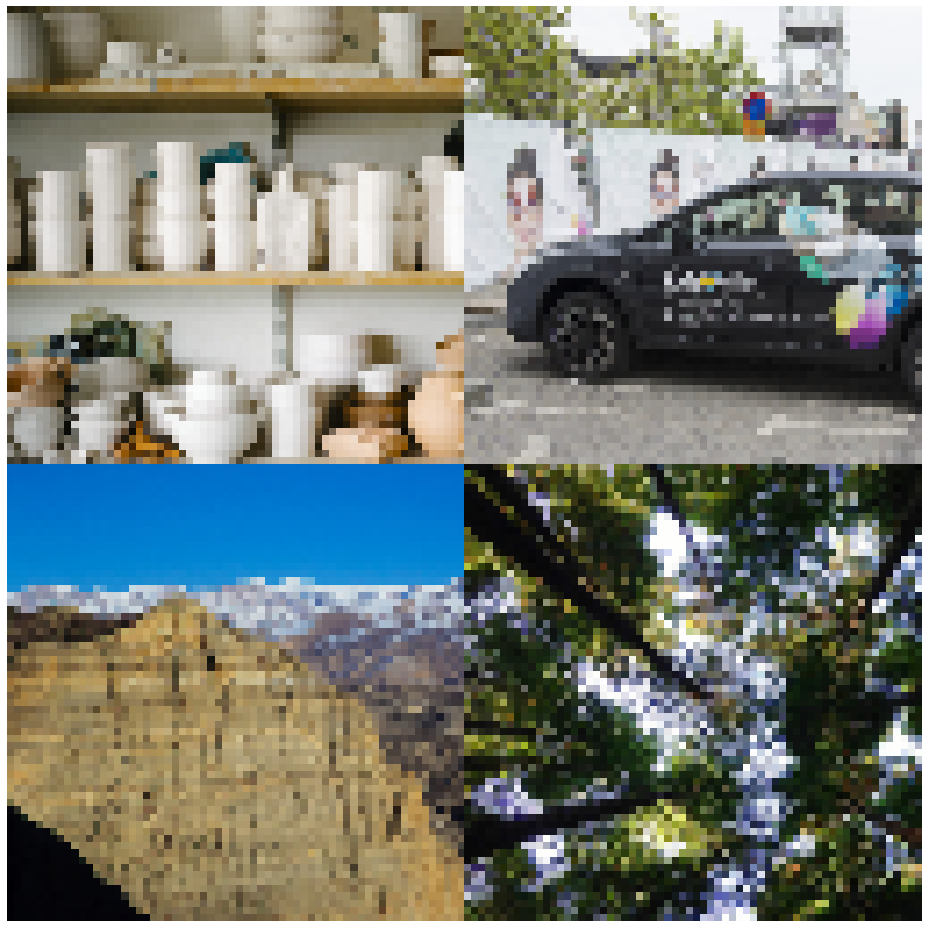

In [0]:
display_batch_of_images(train_lr_img)

# Models SRGAN

In [0]:
from tensorflow.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG19

def _d_conv2d_layers(input_layer, filters, stride, name, batch=True):
  x = Conv2D(filters, kernel_size=3, strides=stride, padding='same', name=name)(input_layer)
  if batch:
    x = BatchNormalization()(x)
  return LeakyReLU()(x)


def model_discriminator(input_shape=(256, 256, 3), filters=64):

  x_input = Input(shape=input_shape, name='D_Input')
  x = Lambda(normalize_m11)(x_input) # image to [-1, 1]

  x = _d_conv2d_layers(x, filters, stride=1, name='D_Conv2D_1_1', batch=False)
  x = _d_conv2d_layers(x, filters, stride=2, name='D_Conv2D_1_2')

  x = _d_conv2d_layers(x, filters*2, stride=1, name='D_Conv2D_2_1')
  x = _d_conv2d_layers(x, filters*2, stride=2, name='D_Conv2D_2_2')

  x = _d_conv2d_layers(x, filters*4, stride=1, name='D_Conv2D_3_1')
  x = _d_conv2d_layers(x, filters*4, stride=2, name='D_Conv2D_3_2')

  x = _d_conv2d_layers(x, filters*8, stride=1, name='D_Conv2D_4_1')
  x = _d_conv2d_layers(x, filters*8, stride=2, name='D_Conv2D_4_2')

  x = Flatten()(x)
  x = Dense(1024)(x)
  x = LeakyReLU()(x)
  x = Dense(1, activation='sigmoid')(x)

  return tf.keras.Model(x_input, x, name='Discriminator')

def _pixel_shuffle(scale):
  return lambda x: tf.nn.depth_to_space(x, scale)

def _residual_block(x_input):

  x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x_input)
  x = BatchNormalization()(x)
  x = PReLU(shared_axes=[1, 2])(x)

  x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = Add()([x_input, x])

  return x


def model_generator(input_shape=(64, 64, 3)):

    x_input = Input(shape=input_shape, name='Generator_Input')
    x = Lambda(normalize_01)(x_input) # Convert Image [0, 255] to [0, 1]

    x = Conv2D(64, kernel_size=9, strides=1, padding='same', name='G_Conv_1')(x)

    # This Copy Need For Layers After Residual Block
    x = x_copy = PReLU(shared_axes=[1, 2])(x)

    # RESIDUAL BLOCKS * 16
    for _ in range(no_residual_blocks):
      x = _residual_block(x)
    
    x = Conv2D(64, kernel_size=3, strides=1, padding='same', name='G_Conv_7')(x)
    x = BatchNormalization()(x)
    x = Add()([x_copy, x])

    # Last Two Layers k=3, n=256, s=1
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', name='G_Conv_8')(x)
    x = tf.keras.layers.Lambda(_pixel_shuffle(scale=2))(x)
    x = PReLU(shared_axes=[1, 2])(x)

    x = Conv2D(256, kernel_size=3, strides=1, padding='same', name='G_Conv_9')(x)
    x = tf.keras.layers.Lambda(_pixel_shuffle(scale=2))(x)
    x = PReLU(shared_axes=[1, 2])(x)

    x = Conv2D(3, kernel_size=9, strides=1, padding='same', activation='tanh', name='G_Conv_10')(x)
    x = tf.keras.layers.Lambda(denormalize_m11)(x) # Convert [-1, 1] to Image 

    return tf.keras.Model(x_input, x, name='Generator')


# VGG Model

In [0]:
def model_vgg19(output_layer = 5):

    """
        Use it for features map from real and generated images
    """

    vgg = VGG19(
        input_shape=[None, None, 3],
        include_top=False)


    return tf.keras.Model(vgg.input,
                       vgg.layers[output_layer].output)

# Custom training loop


## Strategy Scope For SRGAN

In [0]:
with strategy.scope():
    
    discriminator = model_discriminator(input_shape=[*IMAGE_SIZE_HR, 3])
    generator = model_generator(input_shape=[*IMAGE_SIZE_LR, 3])
    # Load Model
    generator.load_weights(DRIVE_PRE_GENERATOR_PATH)

    # 5 or 20
    VGG = model_vgg19(output_layer=no_vgg_block)
    
    
    optimizer_g = tf.keras.optimizers.Adam(learning_rate= lr_example)
    optimizer_d = tf.keras.optimizers.Adam(learning_rate= lr_example)

    # Instantiate metrics
    generator_loss_sum = tf.keras.metrics.Sum()
    discriminator_loss_sum = tf.keras.metrics.Sum()
    content_loss_sum = tf.keras.metrics.Sum()
    perceptual_loss_sum = tf.keras.metrics.Sum()
 
    # G Loss
    def generator_loss(fake_output):
        value = tf.nn.compute_average_loss(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output), global_batch_size=BATCH_SIZE)
        return value

    binary_cross = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

    # D Loss
    def discriminator_loss(real_output, fake_output):
        real_loss = tf.nn.compute_average_loss(binary_cross(tf.ones_like(real_output), real_output), global_batch_size=BATCH_SIZE)
        fake_loss = tf.nn.compute_average_loss(binary_cross(tf.zeros_like(fake_output), fake_output), global_batch_size=BATCH_SIZE)
        return real_loss + fake_loss

    # Content Loss (VGG 19)
    @tf.function
    def content_loss(vgg_model, gen_fake, hr):
      gen_fake = (gen_fake + 1) / 2. # VGG19 used [0, 1]
      hr = (hr + 1) / 2.
      gen_fake_features = vgg_model(gen_fake) 
      hr_features = vgg_model(hr) 
      return tf.nn.compute_average_loss(tf.keras.losses.mean_squared_error(hr_features, gen_fake_features), global_batch_size=BATCH_SIZE)

# Step functions SRGAN

In [0]:
@tf.function
def train_step(dataset, labels):
    lr_img, hr_img = dataset
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(lr_img, training=True)
        
        fake_output = discriminator(generated_images, training=True)
        real_output = discriminator(hr_img, training=True)
        

        # G loss
        cont_loss = content_loss(VGG, generated_images, hr_img)
        gen_loss = generator_loss(fake_output)
        perceptual_loss = cont_loss * coff_cont_loss + gen_loss * coff_gen_loss
        
        # D loss
        disc_loss = discriminator_loss(real_output, fake_output)

    
    grads_d = gen_tape.gradient(disc_loss, discriminator.trainable_variables)
    optimizer_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    grads_g = disc_tape.gradient(perceptual_loss, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(grads_g, generator.trainable_variables))
    
    # update metrics
    discriminator_loss_sum.update_state(disc_loss)
    generator_loss_sum.update_state(gen_loss)
    content_loss_sum.update_state(cont_loss)
    perceptual_loss_sum.update_state(perceptual_loss)

## Save Images

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(16, 16))

  array_of_images = []


  for i in range(predictions.shape[0]):
      plt.subplot(1, 4, i+1)
      new = normalize_01(predictions[i, :, :])
      array_of_images.append(new)
      plt.imshow(array_of_images[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  return array_of_images

## Training loop SRGAN


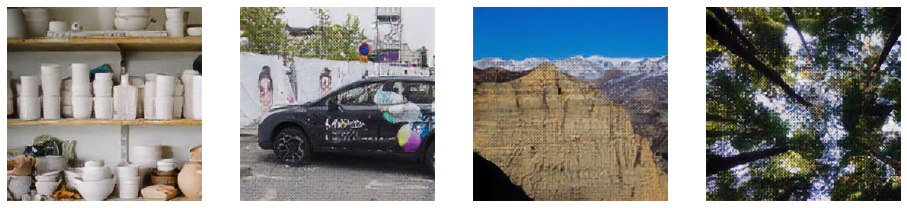

PSNR: 17.370586395263672 SSIM: 0.4030672609806061

EPOCH 201/10000
time: 8.3s d_loss: 0.0000 g_loss: 3644.0462 perceptual_loss: 374.9868 content_loss: 371.3428
=========================|
EPOCH 202/10000
time: 6.7s d_loss: 0.0000 g_loss: 3692.6384 perceptual_loss: 367.3921 content_loss: 363.6995
=========================|
EPOCH 203/10000
time: 6.6s d_loss: 0.0000 g_loss: 3697.9244 perceptual_loss: 354.5337 content_loss: 350.8359
=========================|
EPOCH 204/10000
time: 6.6s d_loss: 0.0000 g_loss: 3660.4506 perceptual_loss: 356.0464 content_loss: 352.3860
=========================|
EPOCH 205/10000
time: 6.6s d_loss: 0.0000 g_loss: 3603.5747 perceptual_loss: 364.8816 content_loss: 361.2780
=========================|
EPOCH 206/10000
time: 6.6s d_loss: 0.0000 g_loss: 3634.4856 perceptual_loss: 363.5584 content_loss: 359.9240
=========================|
EPOCH 207/10000
time: 6.7s d_loss: 0.0000 g_loss: 3635.7425 perceptual_loss: 361.9869 content_loss: 358.3512
========================

KeyboardInterrupt: ignored

In [39]:
start_time = epoch_start_time = time.time()

normalize_hr_for_metrcis = normalize_01(train_hr_img)

# distribute the datset according to the strategy
train_dist_ds_img = strategy.experimental_distribute_dataset(get_training_dataset_images())

print("Steps per epoch:", STEPS_PER_EPOCH)
History = namedtuple('History', 'history')
history = History(history={'d_loss': [], 'perceptual_loss':[], 'g_loss': [], 'content_loss':[]})

epoch = 0
for step, (images) in enumerate(train_dist_ds_img):
    
    # It's just placeholder for strategy.run
    labels = tf.convert_to_tensor(np.zeros((1, 16)))
    # run training step
    strategy.run(train_step, args=(images, labels))
    print('=', end='', flush=True)

    if ((step+1) // STEPS_PER_EPOCH) > epoch:
        print('|', end='', flush=True)

        # compute metrics
        history.history['g_loss'].append(generator_loss_sum.result().numpy() / STEPS_PER_EPOCH)
        history.history['d_loss'].append(discriminator_loss_sum.result().numpy() / STEPS_PER_EPOCH)
        history.history['perceptual_loss'].append(perceptual_loss_sum.result().numpy() / STEPS_PER_EPOCH)
        history.history['content_loss'].append(content_loss_sum.result().numpy() / STEPS_PER_EPOCH)


        if epoch % 100 == 0:
    
          # Produce images for the GIF as we go
          display.clear_output(wait=True)
          array_of_image = generate_and_save_images(generator,
                                  epoch,
                                  train_lr_img)
          
          
          array_for_metrics = tf.convert_to_tensor(array_of_image)
          # Metrics 
          psnr = np.sum(tf.image.psnr(array_for_metrics, normalize_hr_for_metrcis, max_val=1.0)) / 4
          ssim = np.sum(tf.image.ssim(array_for_metrics, normalize_hr_for_metrcis, max_val=1.0)) / 4

        

          print('PSNR: {}'.format(psnr), 
                'SSIM: {}'.format(ssim))
                
        
        # report metrics
        epoch_time = time.time() - epoch_start_time
        print('\nEPOCH {:d}/{:d}'.format(epoch+1, EPOCHS))
        print('time: {:0.1f}s'.format(epoch_time),
              'd_loss: {:0.4f}'.format(history.history['d_loss'][-1]),
              'g_loss: {:0.4f}'.format(history.history['g_loss'][-1]),
              'perceptual_loss: {:0.4f}'.format(history.history['perceptual_loss'][-1]),
              'content_loss: {:0.4f}'.format(history.history['content_loss'][-1]),
              flush=True)

        # set up next epoch
        epoch = (step+1) // STEPS_PER_EPOCH
        epoch_start_time = time.time()
        generator_loss_sum.reset_states()
        discriminator_loss_sum.reset_states()
        content_loss_sum.reset_states()
        perceptual_loss_sum.reset_states()
        
        if epoch >= EPOCHS:
            break
    
simple_ctl_training_time = time.time() - start_time
print("SIMPLE CTL TRAINING TIME: {:0.1f}s".format(simple_ctl_training_time))

generator.save(f'/content/drive/My Drive/SRGAN/models_tpu/{date}-generator.h5')
discriminator.save(f'/content/drive/My Drive/SRGAN/models_tpu/{date}-discriminator.h5')